In [21]:
import os
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import re

import matplotlib.pyplot as plt



## dataset

In [50]:
root = Path('/home/data/Imagenet')
train_path = root / 'train'
val_path = root / 'val'
label_path = root / 'label'

def ImgNetData(train_path, val_path):
    train_transforms = transforms.Compose([
        transforms.RandomChoice([transforms.Resize(256), transforms.Resize(480)]),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        
        ### 이걸로 사용해볼 순 없나?
        # transforms.RandomResizedCrop((224,224)),
        # transforms.Resize((256,256)),
        # transforms.CenterCrop((224,224)),
        
        transforms.RandomHorizontalFlip(0.5),
    ])
    val_transforms = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    train_data = ImageFolder(root=train_path, transform=train_transforms)
    val_data = ImageFolder(root=val_path, transform=val_transforms)
    
    return train_data, val_data
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


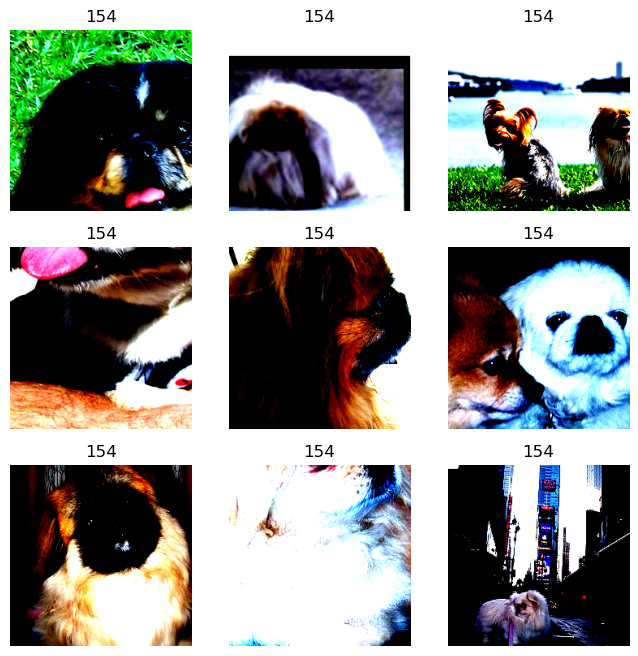

In [89]:
plt.figure(figsize=(8, 8))
for i in range(9):
    img, label = train_data[i+200000]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis("off")
plt.show()

In [69]:
def synset2word(synset_path=synset_path):
    label_dict = {}
    with open(synset_path, 'r') as f:
        synset_word = f.readlines()
        for i in range(len(synset_word)):
            synset = synset_word[i].split()[0]
            word = re.sub(r'[^a-zA-Z]', '', synset_word[i].split()[1])
            label_dict[synset] = word
            
    return label_dict

        

1000

## Model

In [188]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleNeck, self).__init__()
        
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion),
        )
        self.expansion = 4
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        
        # 하위 layer로 내려갈때 downsampling(1/2줄이기)하면서 feature 수가 달라짐 그러므로 skip connection을 할 수 있게 보정
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
    def forward(self, x):
        out = self.residual_function(x)
        out = out + self.shortcut(x)
        return self.relu(out)
        
    

In [189]:
model = BottleNeck(64,256)
print(model.expansion)

4


In [192]:
class ResNet(nn.Module):
    def __init__(self, block, layers=[3,4,6,3], in_channels=3, num_classes=1000):
        self.num_classes = num_classes
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            
        )        
        self.conv2 = self._make_layer(block, 64, layers[0])
        self.conv3 = self._make_layer(block, 128, layers[1], downsampling=True)
        self.conv4 = self._make_layer(block, 256, layers[2], downsampling=True)
        self.conv5 = self._make_layer(block, 512, layers[3], downsampling=True)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out
    
    def _make_layer(self, block, out_channels, num_blocks, downsampling=False):
        if downsampling is True:
            stride = 2
        else:
            stride = 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)
    

import torchsummary
model = ResNet(BottleNeck)
torchsummary.summary(model, (3,224,224), device='cpu')
# print(model)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,